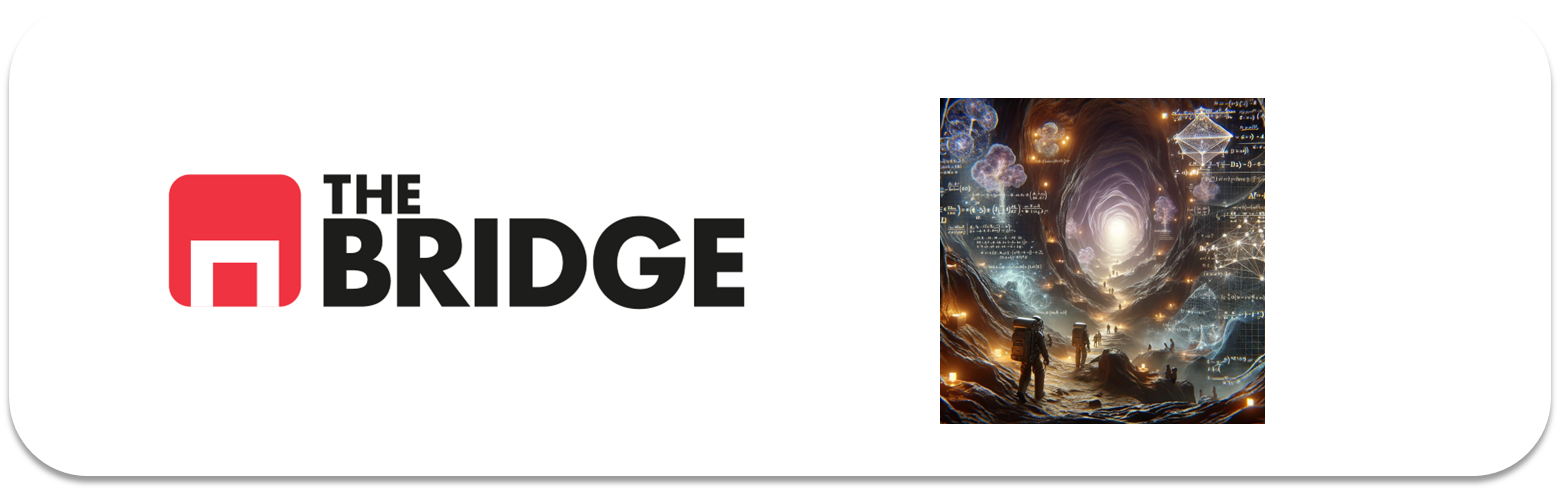

## PRACTICA OBLIGATORIA: **Introducción Deep Learning**

* La práctica obligatoria de esta unidad consiste en un único ejercicio de modelado del dataset del titanic empleando y comparando dos modelos diferentes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv("./data/titanic.csv")
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


In [4]:
df.drop(columns = ["class", "embark_town", "alive", "adult_male", "deck" ], inplace=True)
target= "survived"

In [5]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,who,alone
0,0,3,male,22.0,1,0,7.2500,S,man,False
1,1,1,female,38.0,1,0,71.2833,C,woman,False
2,1,3,female,26.0,0,0,7.9250,S,woman,True
3,1,1,female,35.0,1,0,53.1000,S,woman,False
4,0,3,male,35.0,0,0,8.0500,S,man,True


In [6]:
df["embarked"].value_counts(dropna=False)

embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64

In [7]:
df.loc[df["embarked"].isna(), "embarked"] = df["embarked"].mode()[0]

In [8]:
#Age --> imputamos la media según el género
hombres = df.who =="man"
mujeres = df.who =="woman"
niños = df.who == "child"

mean_hombres = df[hombres]["age"].mean()
mean_mujeres = df[mujeres]["age"].mean()
mean_niños = df[niños]["age"].mean()

es_nulo = df.age.isna()

df.loc[hombres & es_nulo, "age"] = mean_hombres
df.loc[mujeres & es_nulo, "age"] = mean_mujeres
df.loc[niños & es_nulo, "age"] = mean_niños

### Split train y test y target

In [9]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 42)

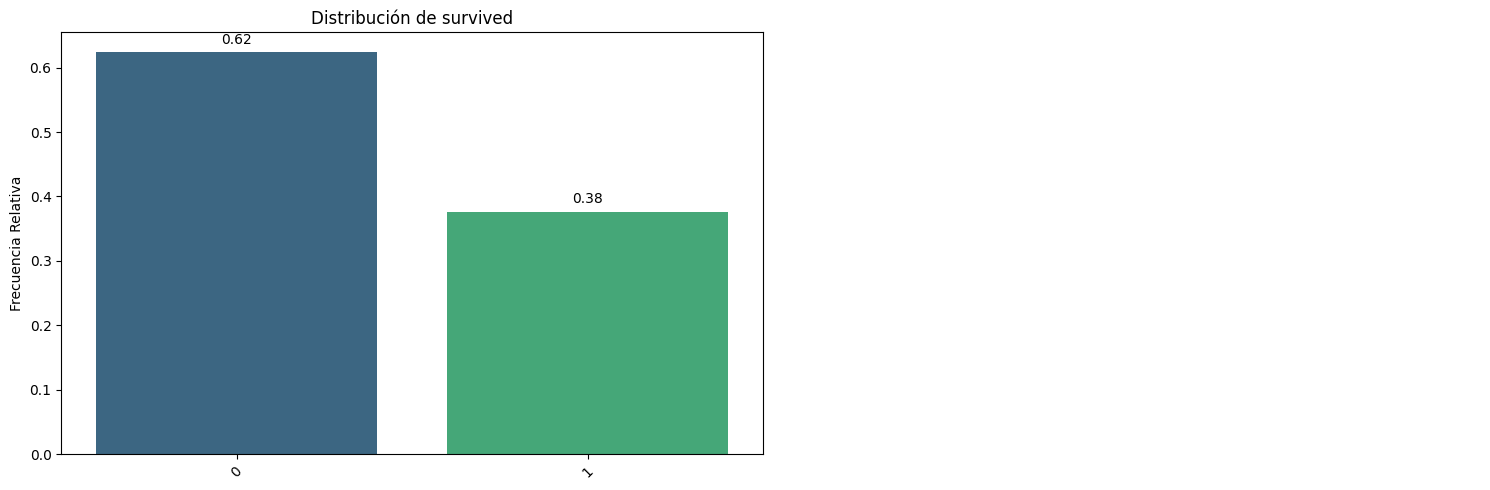

In [10]:
bt.pinta_distribucion_categoricas(train_set, [target], True, True)

In [11]:
X_train = train_set.drop(columns=[target])
y_train = train_set[target]

X_test = test_set.drop(columns=[target])
y_test = test_set[target]

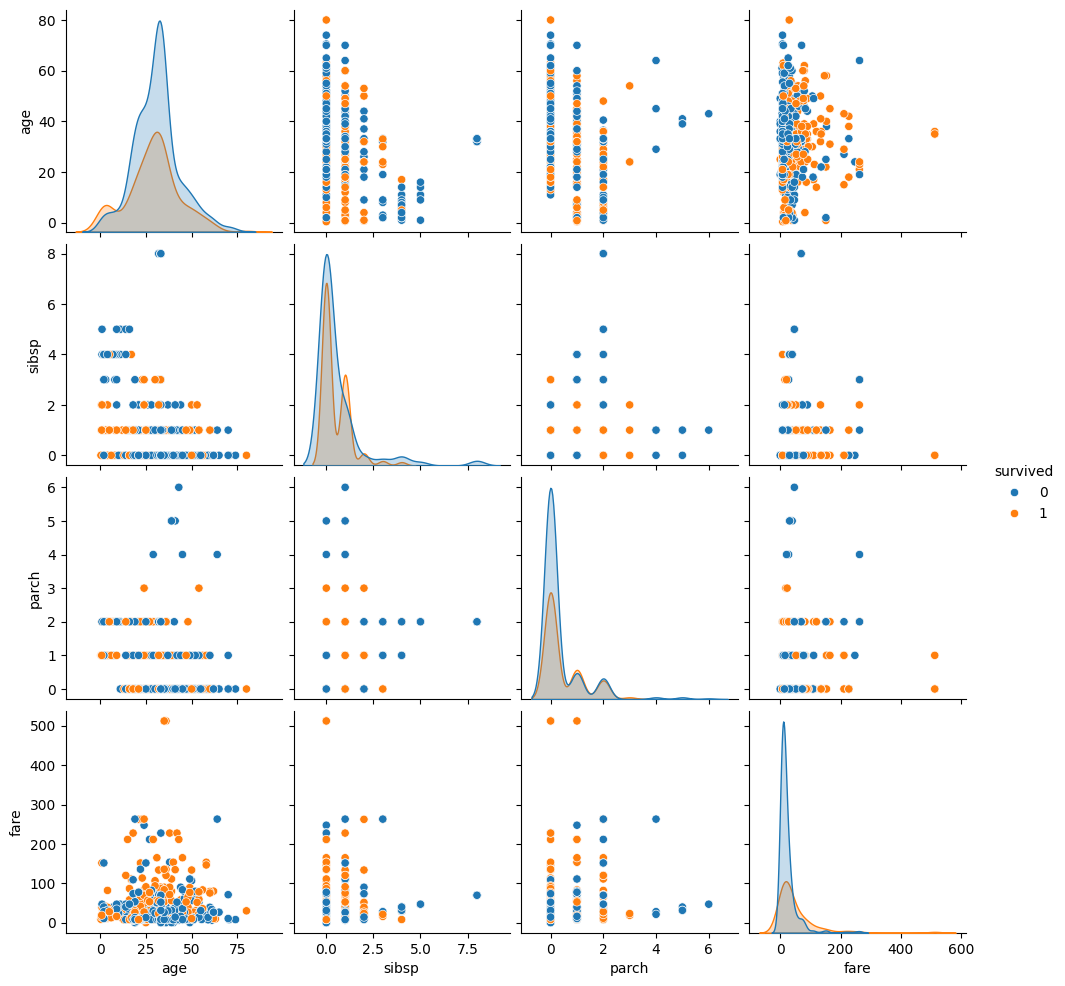

In [12]:
features_num = ["age", "sibsp", "parch", "fare", target]
sns.pairplot(train_set[features_num], hue=target)

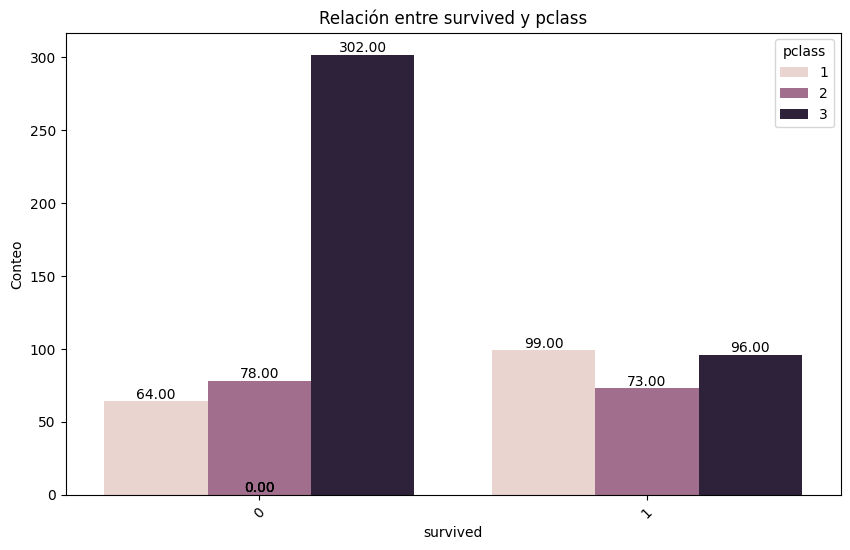

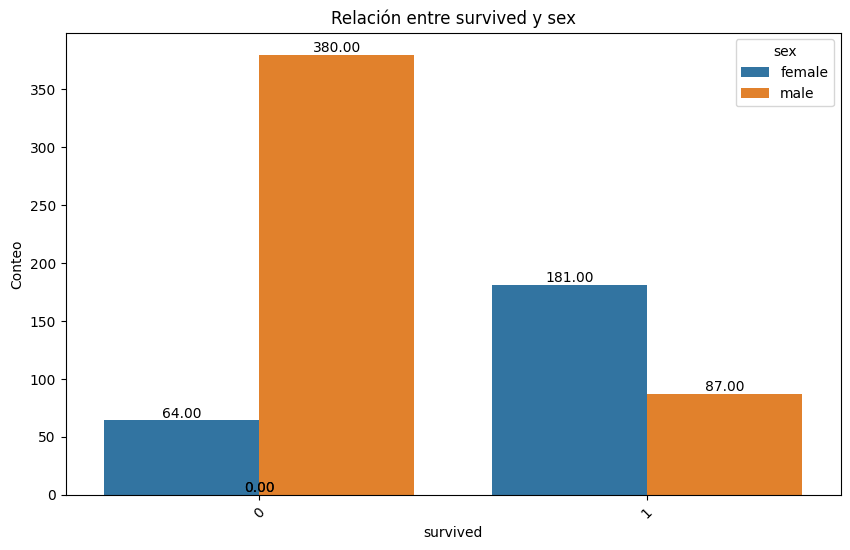

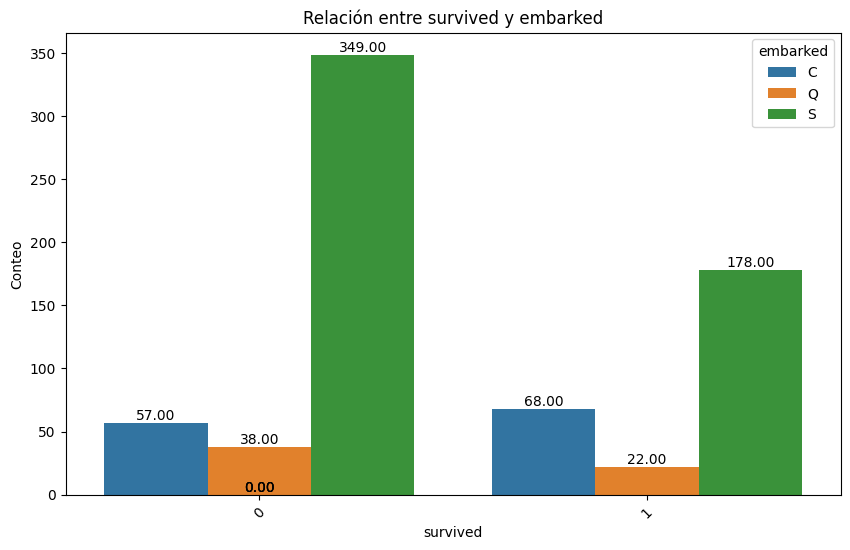

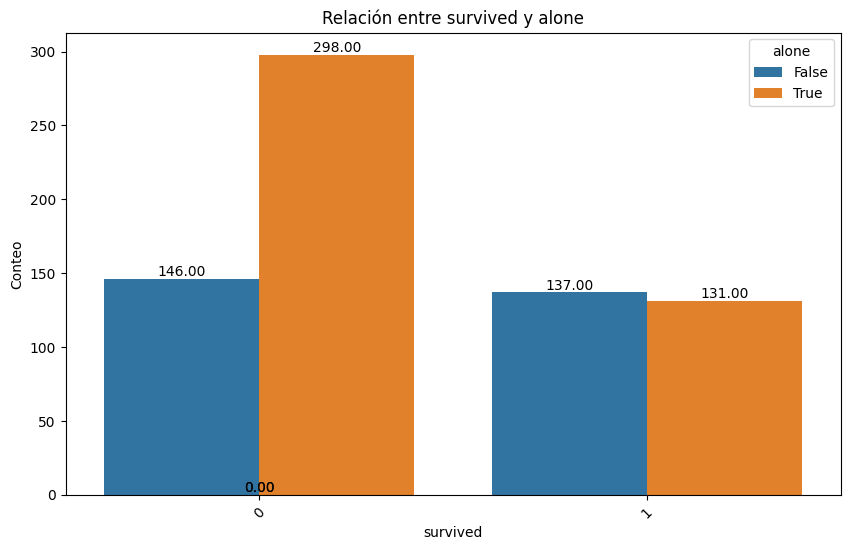

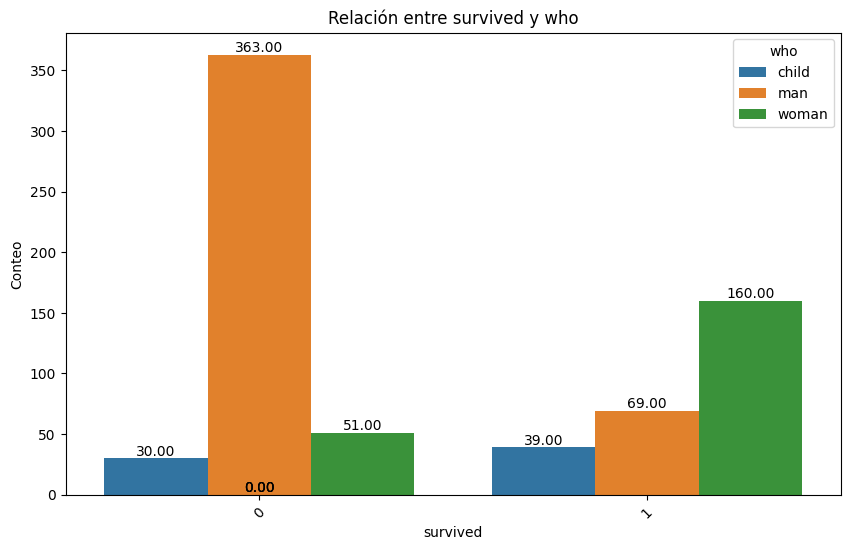

In [13]:
features_cat= ["pclass", "sex", "embarked", "alone", "who"]
for columna in features_cat:
    bt.plot_categorical_relationship_fin(train_set, target, columna, show_values=True)

In [14]:
# One-hot encoding 
X_train = pd.get_dummies(X_train, columns=["embarked", "sex", "who"], dtype=int )
X_test = pd.get_dummies(X_test, columns=["embarked", "sex", "who"], dtype=int)

In [15]:
from sklearn.preprocessing import StandardScaler

# Inicializar el escalador
scaler = StandardScaler()

features_num= ["age", "sibsp", "parch", "fare"]

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Ajustar y transformar
X_train_scaled[features_num] = scaler.fit_transform(X_train[features_num])
X_test_scaled[features_num] = scaler.transform(X_test[features_num])

## MODELOS

### Descripción y objetivo

El objetivo de la práctica es crear un modelo DL y compararlo con un modelo Random Forest para el dataset de titanic los dos con el mismo objetivo, predecir la supervivencia de un pasajero.  Se pide:  
1. Desarrollar el proceso de ML hasta crear los dos modelos DL y Random Forest. El primero debe tener una topología MLP (es decir una red densa) con un máximo de 3 capas ocultas y debes emplear sklearn para crearlo. No es necesario hacer una análisis/seleccion exahustivo. Escoge una métrica acorde al tipo de target del problema. 

2. Ambos modelos deben tener sus hiperparámetros optimizados, mediante GridSearch. Para ello: utiliza el grid de parámetros que creas conveniente para Random Forest y para el modelo DL, utiliza un grid con los hiperparámetros siguientes:'hidden_layer_sizes','activation', 'solver','alpha' y 'learning_rate'. Para los rangos del grid del modelo de DL guíate por lo visto en el workout y por los posibles valores que se indican en la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier). Prueba por lo menos una topología con una sola capa oculta y otra con más de una capa oculta.   
NOTA: Incluye los valores por defecto de los hiperparámetros escogidos en cada caso dentro del grid de hiperparámetros. 
  

3. Compara los modelos respecto a sus métricas medias de accuracy, precision, recall y tiempos de entrenamiento (para ello tendrás que realizar un entrenamiento a parte del mejor modelo obtenido en la optimización de hiperparámetros) y decide cuál te quedarías argumentándolo.    

4. Para el mejor modelo DL obtenido, muestra su clasification report, y la matriz de confusión comentando el resultado.


In [16]:
#RandomForest

rf = RandomForestClassifier(random_state=42)

param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [3,4,5,6,10,15,17], 
    "max_features": ["sqrt", 3, 4] 
}

start_rf = time.time()
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)
end_rf = time.time()

best_rf = grid_rf.best_estimator_
train_time = round(end_rf - start_rf, 2)

start = time.time()
y_pred = best_rf.predict(X_test)
end = time.time()

pred_time = end - start

rf_metrics = pd.DataFrame({'accuracy': accuracy_score(y_test, y_pred),
                            'precision': precision_score(y_test, y_pred, average = "macro"),
                            'recall': recall_score(y_test, y_pred, average = "macro"),
                            'train_time': train_time,
                            'pred_time': pred_time}, index=['rf']
                            )
rf_metrics.head()

,accuracy,precision,recall,train_time,pred_time
rf,0.810056,0.808595,0.796203,16.62,0.023075


In [17]:
#MLP

mlp = MLPClassifier(max_iter=500, random_state=42)

param_grid_mlp = {
    'hidden_layer_sizes': [(100,), (50, 50)],
    'activation': ['relu', 'tanh'],              # default: relu
    'solver': ['adam', 'lbfgs'],                 # default: adam
    'alpha': [0.0001, 0.001],                    # default: 0.0001
    'learning_rate': ['constant', 'adaptive']    # default: constant
}

start_mlp = time.time()
grid_mlp = GridSearchCV(mlp, param_grid_mlp, cv=5, scoring='accuracy', n_jobs=-1)
grid_mlp.fit(X_train_scaled, y_train)
end_mlp = time.time()

best_mlp = grid_mlp.best_estimator_
train_time = round(end_mlp - start_mlp, 2)


start = time.time()
y_pred = best_mlp.predict(X_test_scaled)
end = time.time()

pred_time = end - start

mlp_metrics = pd.DataFrame({'accuracy': accuracy_score(y_test, y_pred),
                            'precision': precision_score(y_test, y_pred, average = "macro"),
                            'recall': recall_score(y_test, y_pred, average = "macro"),
                            'train_time': train_time,
                            'pred_time': pred_time}, index=['mlp']
                            )
mlp_metrics.head()

c:\Users\emmag\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


,accuracy,precision,recall,train_time,pred_time
mlp,0.787709,0.788324,0.769176,31.53,0.003427


In [18]:
metrics = pd.concat([rf_metrics, mlp_metrics])
metrics.head()

,accuracy,precision,recall,train_time,pred_time
rf,0.810056,0.808595,0.796203,16.62,0.023075
mlp,0.787709,0.788324,0.769176,31.53,0.003427


*Me quedaría con RandomForest por tener mejores métricas y considerando la diferencia de tiempo de entrenamiento*

Mejores hiperparámetros MLP: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}

Classification Report (MLP):

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       105
           1       0.79      0.66      0.72        74

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.77       179
weighted avg       0.79      0.79      0.78       179



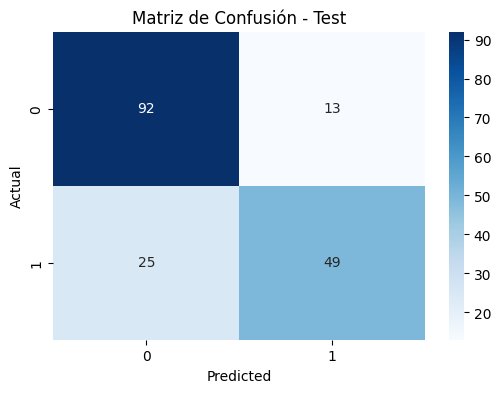

In [19]:
#Evaluación mejor modelo DL

print("Mejores hiperparámetros MLP:", grid_mlp.best_params_)

# Reporte
print("\nClassification Report (MLP):\n")
print(classification_report(y_test, y_pred))

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - Test')
plt.show()

- El modelo tiene una accuracy del 79%, equilibrada.
- Clasifica bien la clase 0 (no sobrevivió), con recall de 0.88.
- Para la clase 1 (sobrevivió), el recall baja a 0.66, lo que indica que pierde varios verdaderos positivos (25 en la matriz de confusión). Es decir, el modelo tiende a predecir más la clase mayoritaria.
